### Import the required packages

In [2]:
import torch
import random
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, random_split

### Load the data and create the Train, Validation and Test datasets

In [3]:
# Used for finding the mean and std of the dataset
#mean = X_train.train_data.float().mean() / 255 # = 0.1307
#std = X_train.train_data.float().std() / 255 # = 0.3081

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

### Check the data

In [ ]:
print(f'train_dataset data shape: {train_dataset.dataset.data[train_dataset.indices].shape}')
print(f'train_dataset targets shape: {train_dataset.dataset.targets[train_dataset.indices].shape}')

print(f'val_dataset data shape: {val_dataset.dataset.data[val_dataset.indices].shape}')
print(f'val_dataset targets shape: {val_dataset.dataset.targets[val_dataset.indices].shape}')

print(f'test_dataset data shape: {test_dataset.data.shape}')
print(f'test_datset targets shape: {test_dataset.targets.shape}')

print(f'Classes: {train_dataset.dataset.classes}')

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_dataset.dataset.data[train_dataset.indices][i], cmap='gray')
    plt.xlabel(f'Label: {train_dataset.dataset.targets[train_dataset.indices][i]}')

### Check the data distribution

In [ ]:
y_train = train_dataset.dataset.targets[train_dataset.indices].numpy()
y_val = val_dataset.dataset.targets[val_dataset.indices].numpy()
y_test = test_dataset.targets.numpy()
    
datasets = {
    'Train': y_train,
    'Val': y_val,
    'Test': y_test
}
    
data = []
for set_name, y_data in datasets.items():
    unique, counts = np.unique(y_data, return_counts=True)
    for digit, count in zip(unique, counts):
        data.append({
            'Dataset': set_name,
            'Digit': digit,
            'Count': count
        })
    
df = pd.DataFrame(data)
    
plt.figure(figsize=(15, 8))
df_pivot = df.pivot(index='Digit', columns='Dataset', values='Count')
df_pivot.plot(kind='bar', width=0.8)
    
plt.title('Digit distribution in MNIST datasets')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.legend(title='Dataset', loc='upper right')
plt.grid(True, alpha=0.3)
    
plt.show()

### Model class and helper functions

In [4]:
class Net(nn.Module):
    def __init__(self, input_size, n_neurons, num_classes):
        super(Net, self).__init__()
        layers = []

        current_size = input_size

        for neurons in n_neurons:
            layers.extend([
                nn.Linear(current_size, neurons),
                nn.ReLU()
            ])
            current_size = neurons

        layers.append(nn.Linear(current_size, num_classes))

        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)
    
def create_dataloaders(dataset, batch_size, num_workers, shuffle):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=True
    )
    
def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias) 

def create_model(input_size, n_neurons, num_classes, learning_rate, eta_minus, eta_plus, min_step, max_step, device):
    model = Net(input_size, n_neurons, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Rprop(
        model.parameters(),
        lr=learning_rate,
        etas=(eta_minus, eta_plus),
        step_sizes=(min_step, max_step)
    )

    model.apply(weights_init)

    return model, criterion, optimizer

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, patience, min_delta, verbose):
    train_losses = []
    val_losses = []
    val_accuracies = []
    patience_counter = 0
    best_val_loss = float('inf')
    best_model_state = None
    n_total_steps = len(train_loader)

    for epoch in range(num_epochs):
        
        total_train_loss = 0.0
        n_train_samples = 0

        # Training phase
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * labels.size(0)
            n_train_samples += labels.size(0)

            if verbose and (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}]')

        avg_train_loss = total_train_loss / n_train_samples
        train_losses.append(avg_train_loss)

        # Validation phase
        val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Early stopping check
        if best_val_loss - val_loss > min_delta:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        print(f'Epoch [{epoch+1}/{num_epochs}], Train loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return train_losses, val_losses, val_accuracies
    
def validate_model(model, val_loader, criterion, device):
    total_loss = 0.0
    n_samples = 0
    n_correct = 0
    
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)
            n_samples += labels.size(0)

            _, predicted = torch.max(outputs, 1)
            n_correct += (predicted == labels).sum().item()

        avg_loss = total_loss / n_samples
        accuracy = 100.0 * n_correct / n_samples
    
    return avg_loss, accuracy

def plot_predictions(model, test_loader, device, num_images=1):
    model.eval()
    
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    
    indices = np.random.randint(0, len(images), num_images)
    
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images.reshape(-1, 28*28))
        probabilities = nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        
        for idx in indices:
            plt.figure(figsize=(12,4))
            
            plt.subplot(1, 2, 1)
            plt.imshow(images[idx].cpu().reshape(28, 28), cmap='gray')
            plt.title(f'True: {labels[idx].item()}\nPredicted: {predicted[idx].item()}')
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            probs = probabilities[idx].cpu().numpy()
            plt.bar(range(10), probs)
            plt.xticks(range(10))
            plt.ylim([0, 1])
            plt.title('Prediction probabilities')
            
            plt.tight_layout()
            plt.show()

def plot_results(train_losses, val_losses, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    epochs = range(1, len(train_losses) + 1)
    ax1.plot(epochs, train_losses, '--', label='Train', alpha=0.7)
    ax1.plot(epochs, val_losses, '-', label='Validation')
    
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot validation accuracy
    ax2.plot(epochs, val_accuracies, label='Validation')
    
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def plot_fold_results(fold_train_losses, fold_val_losses, fold_val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    for fold_idx, (train_losses, val_losses) in enumerate(zip(fold_train_losses, fold_val_losses)):
        epochs = range(1, len(train_losses) + 1)
        ax1.plot(epochs, train_losses, '--', label=f'Fold {fold_idx+1} (Train)', alpha=0.7)
        ax1.plot(epochs, val_losses, '-', label=f'Fold {fold_idx+1} (Val)')
    
    ax1.set_title('Training and Validation Loss per Fold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot validation accuracies
    for fold_idx, acc in enumerate(fold_val_accuracies):
        epochs = range(1, len(acc) + 1)
        ax2.plot(epochs, acc, label=f'Fold {fold_idx+1}')
    
    ax2.set_title('Validation Accuracy per Fold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Model definition, training and testing (no kfold for fast evaluation)

In [ ]:
seed = 42

set_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters for the neural network
input_size = 784
n_neurons = (128, 64)
num_classes = 10

# Hyperparameters for the training
num_epochs = 300
batch_size = len(train_dataset)
learning_rate = 0.01

# Hyperparameters for the Rprop optimizer
eta_minus = 0.5
eta_plus = 1.2
min_step = 1e-6
max_step = 50

# Hyperparameters for early stopping
patience = 3
min_delta = 0.050

train_loader = create_dataloaders(train_dataset, batch_size, num_workers=8, shuffle=True)
val_loader = create_dataloaders(val_dataset, batch_size, num_workers=8, shuffle=False)
test_loader = create_dataloaders(test_dataset, batch_size, num_workers=8, shuffle=False)

model, criterion, optimizer = create_model(
    input_size, 
    n_neurons, 
    num_classes, 
    learning_rate, 
    eta_minus, 
    eta_plus, 
    min_step, 
    max_step, 
    device
)

train_losses, val_losses, val_accuracies = train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    device, 
    num_epochs, 
    patience,
    min_delta, 
    verbose=True
)

plot_results(train_losses, val_losses, val_accuracies)

### Model testing

In [ ]:
_, acc = validate_model(model, test_loader, criterion, device)
print(f'Test accuracy: {acc:.2f}%')

plot_predictions(model, test_loader, device)

### KFold cross validation with random search


Trial 1/10
Testing parameters: {'n_neurons': (64,), 'eta_minus': 0.5, 'eta_plus': 1.4, 'min_step': 1e-05, 'max_step': 50.0}
FOLD 1/3
Epoch [1/300], Train loss: 2.8079, Val Loss: 4.1015, Val Acc: 18.41%
Epoch [2/300], Train loss: 4.0802, Val Loss: 2.4178, Val Acc: 40.56%
Epoch [3/300], Train loss: 2.4015, Val Loss: 2.1367, Val Acc: 58.36%
Epoch [4/300], Train loss: 2.1280, Val Loss: 1.3445, Val Acc: 66.61%
Epoch [5/300], Train loss: 1.3270, Val Loss: 1.3166, Val Acc: 64.69%
Epoch [6/300], Train loss: 1.3230, Val Loss: 0.9324, Val Acc: 74.71%
Epoch [7/300], Train loss: 0.9264, Val Loss: 0.8748, Val Acc: 76.21%
Epoch [8/300], Train loss: 0.8670, Val Loss: 0.5788, Val Acc: 84.67%
Epoch [9/300], Train loss: 0.5696, Val Loss: 0.7132, Val Acc: 81.64%
Epoch [10/300], Train loss: 0.7031, Val Loss: 0.5445, Val Acc: 85.28%
Epoch [11/300], Train loss: 0.5347, Val Loss: 0.3941, Val Acc: 89.38%
Epoch [12/300], Train loss: 0.3850, Val Loss: 0.3944, Val Acc: 89.26%
Epoch [13/300], Train loss: 0.3791,

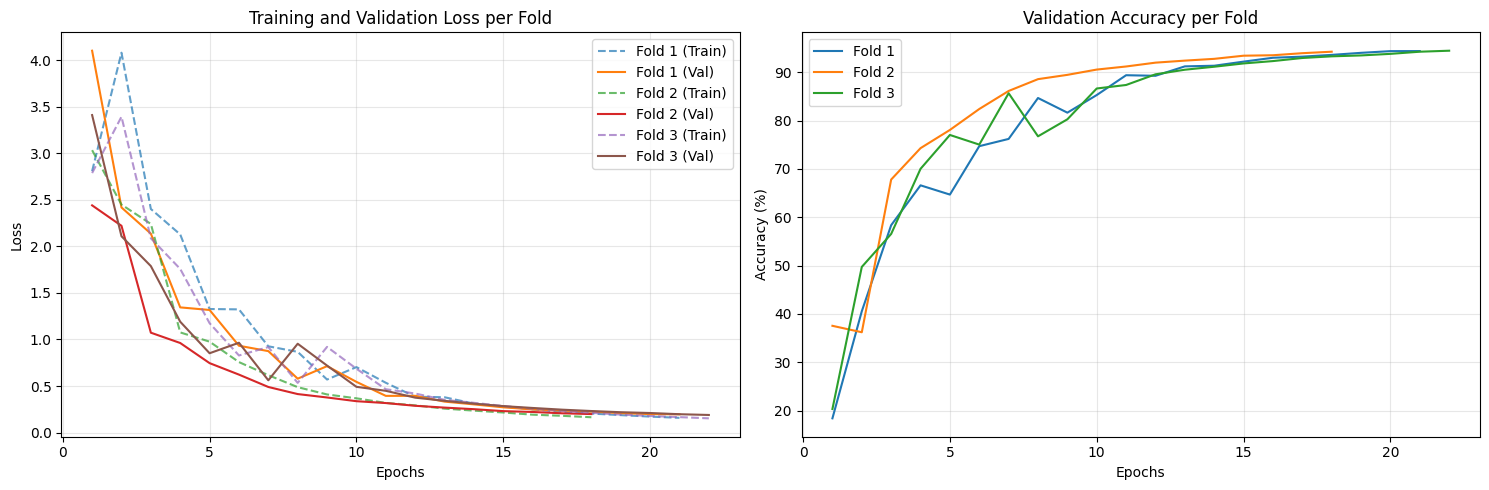


Trial 1 completed:
Parameters: {'n_neurons': (64,), 'eta_minus': 0.5, 'eta_plus': 1.4, 'min_step': 1e-05, 'max_step': 50.0}
Average accuracy across folds: 94.3563 ± 0.0852

Trial 2/10
Testing parameters: {'n_neurons': (64,), 'eta_minus': 0.7, 'eta_plus': 1.4, 'min_step': 1e-05, 'max_step': 60.0}
FOLD 1/3
Epoch [1/300], Train loss: 2.8158, Val Loss: 2.3855, Val Acc: 44.50%
Epoch [2/300], Train loss: 2.3873, Val Loss: 2.0788, Val Acc: 49.24%
Epoch [3/300], Train loss: 2.0734, Val Loss: 1.2757, Val Acc: 65.71%
Epoch [4/300], Train loss: 1.2664, Val Loss: 1.1986, Val Acc: 68.02%
Epoch [5/300], Train loss: 1.1965, Val Loss: 0.8791, Val Acc: 77.44%
Epoch [6/300], Train loss: 0.8504, Val Loss: 0.9061, Val Acc: 76.82%
Epoch [7/300], Train loss: 0.8916, Val Loss: 0.7172, Val Acc: 81.89%
Epoch [8/300], Train loss: 0.6997, Val Loss: 0.5565, Val Acc: 85.97%
Epoch [9/300], Train loss: 0.5375, Val Loss: 0.5548, Val Acc: 86.01%
Epoch [10/300], Train loss: 0.5361, Val Loss: 0.4330, Val Acc: 88.98%
Ep

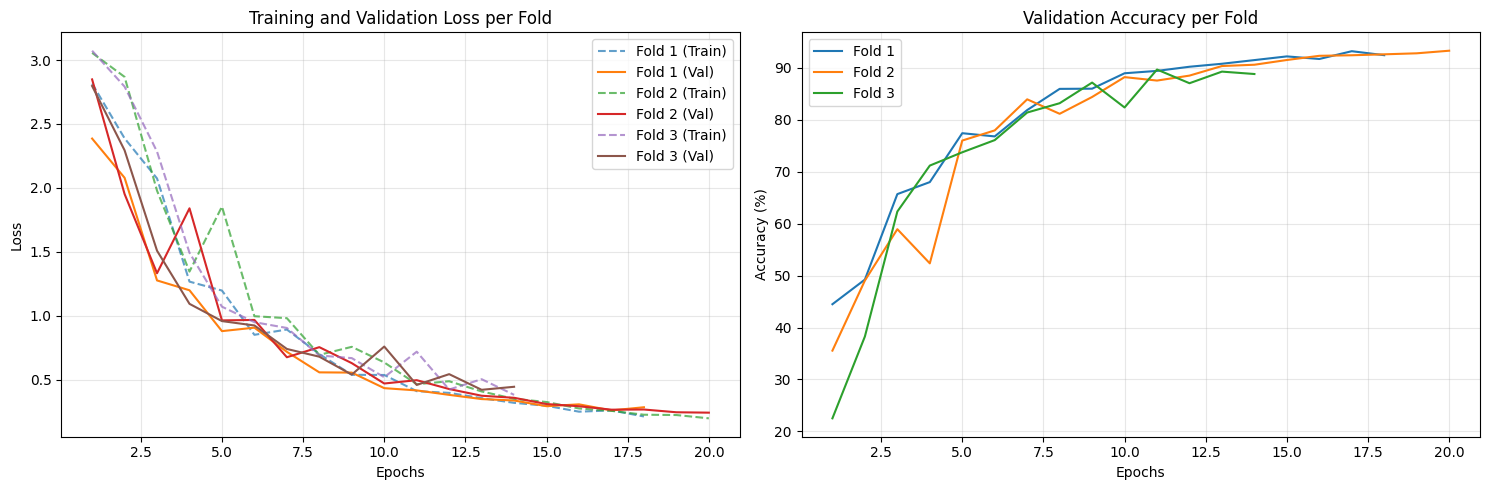


Trial 2 completed:
Parameters: {'n_neurons': (64,), 'eta_minus': 0.7, 'eta_plus': 1.4, 'min_step': 1e-05, 'max_step': 60.0}
Average accuracy across folds: 92.0854 ± 1.6872

Trial 3/10
Testing parameters: {'n_neurons': (128, 64), 'eta_minus': 0.5, 'eta_plus': 1.2, 'min_step': 1e-05, 'max_step': 50.0}
FOLD 1/3
Epoch [1/300], Train loss: 2.7725, Val Loss: 1.6456, Val Acc: 50.11%
Epoch [2/300], Train loss: 1.6408, Val Loss: 3.1015, Val Acc: 26.95%
Epoch [3/300], Train loss: 3.1208, Val Loss: 1.2927, Val Acc: 57.52%
Epoch [4/300], Train loss: 1.2891, Val Loss: 1.1997, Val Acc: 64.88%
Epoch [5/300], Train loss: 1.1757, Val Loss: 1.1658, Val Acc: 66.34%
Epoch [6/300], Train loss: 1.1798, Val Loss: 0.6248, Val Acc: 80.08%
Epoch [7/300], Train loss: 0.6259, Val Loss: 0.7796, Val Acc: 77.51%
Epoch [8/300], Train loss: 0.7605, Val Loss: 0.5248, Val Acc: 83.28%
Epoch [9/300], Train loss: 0.5128, Val Loss: 0.4824, Val Acc: 84.22%
Epoch [10/300], Train loss: 0.4822, Val Loss: 0.4323, Val Acc: 86.22

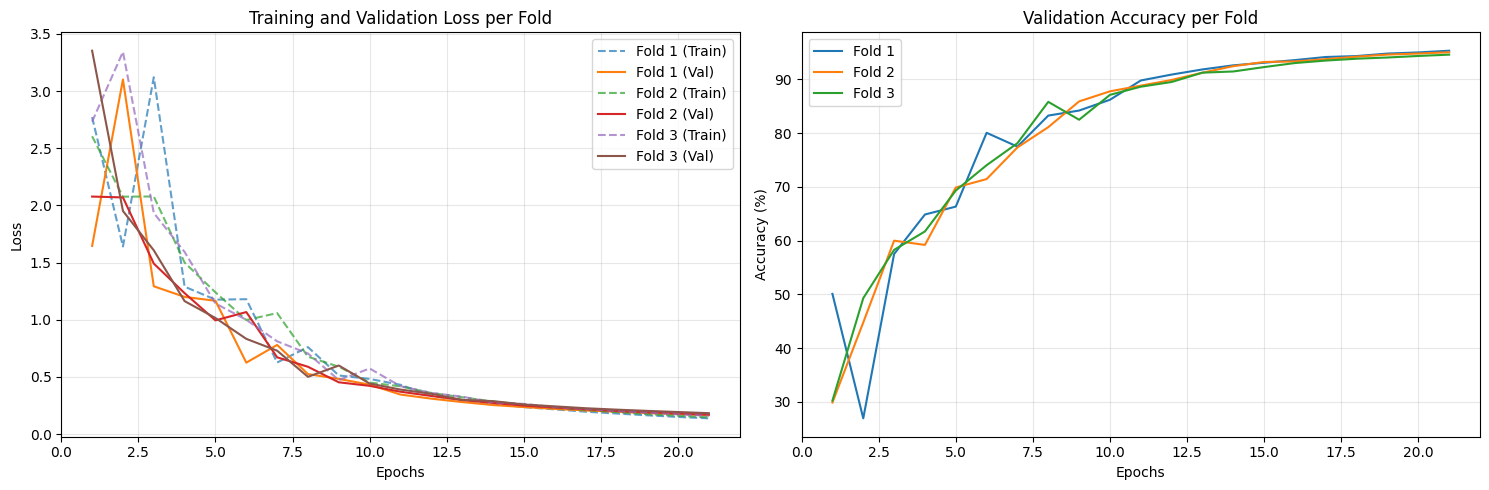


Trial 3 completed:
Parameters: {'n_neurons': (128, 64), 'eta_minus': 0.5, 'eta_plus': 1.2, 'min_step': 1e-05, 'max_step': 50.0}
Average accuracy across folds: 95.0104 ± 0.3008

Trial 4/10
Testing parameters: {'n_neurons': (128,), 'eta_minus': 0.7, 'eta_plus': 1.2, 'min_step': 1e-06, 'max_step': 70.0}
FOLD 1/3
Epoch [1/300], Train loss: 3.1882, Val Loss: 3.8330, Val Acc: 41.09%
Epoch [2/300], Train loss: 3.8232, Val Loss: 4.9300, Val Acc: 39.58%
Epoch [3/300], Train loss: 4.9136, Val Loss: 2.5558, Val Acc: 62.10%
Epoch [4/300], Train loss: 2.5430, Val Loss: 1.4871, Val Acc: 67.50%
Epoch [5/300], Train loss: 1.4978, Val Loss: 1.0780, Val Acc: 74.16%
Epoch [6/300], Train loss: 1.0777, Val Loss: 0.6595, Val Acc: 83.03%
Epoch [7/300], Train loss: 0.6409, Val Loss: 1.0301, Val Acc: 76.45%
Epoch [8/300], Train loss: 0.9967, Val Loss: 0.8617, Val Acc: 79.79%
Epoch [9/300], Train loss: 0.8484, Val Loss: 0.6102, Val Acc: 84.06%
Epoch [10/300], Train loss: 0.5911, Val Loss: 0.5739, Val Acc: 86.1

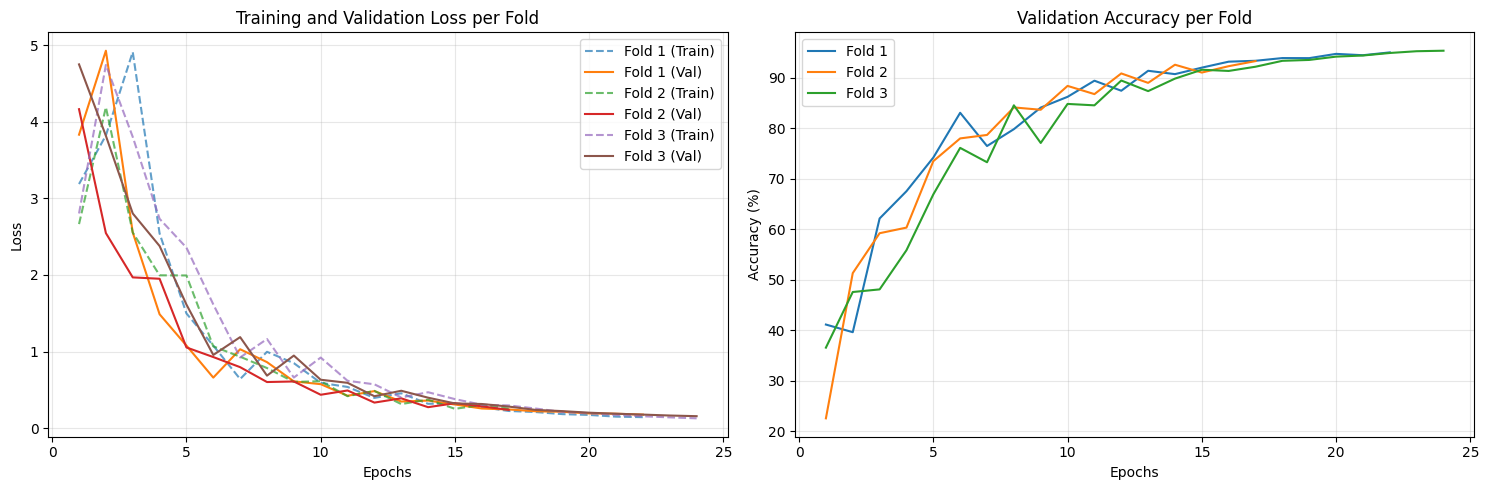


Trial 4 completed:
Parameters: {'n_neurons': (128,), 'eta_minus': 0.7, 'eta_plus': 1.2, 'min_step': 1e-06, 'max_step': 70.0}
Average accuracy across folds: 94.5292 ± 0.9015

Trial 5/10
Testing parameters: {'n_neurons': (128,), 'eta_minus': 0.6, 'eta_plus': 1.3, 'min_step': 1e-06, 'max_step': 60.0}
FOLD 1/3
Epoch [1/300], Train loss: 2.6543, Val Loss: 5.3363, Val Acc: 22.33%
Epoch [2/300], Train loss: 5.3516, Val Loss: 3.1701, Val Acc: 49.98%
Epoch [3/300], Train loss: 3.1867, Val Loss: 2.1005, Val Acc: 60.52%
Epoch [4/300], Train loss: 2.0599, Val Loss: 2.3384, Val Acc: 59.63%
Epoch [5/300], Train loss: 2.3398, Val Loss: 0.9294, Val Acc: 77.74%
Epoch [6/300], Train loss: 0.9213, Val Loss: 1.3723, Val Acc: 72.09%
Epoch [7/300], Train loss: 1.3653, Val Loss: 0.8866, Val Acc: 78.27%
Epoch [8/300], Train loss: 0.8842, Val Loss: 0.7084, Val Acc: 83.10%
Epoch [9/300], Train loss: 0.6996, Val Loss: 0.5720, Val Acc: 86.74%
Epoch [10/300], Train loss: 0.5499, Val Loss: 0.5576, Val Acc: 85.33%


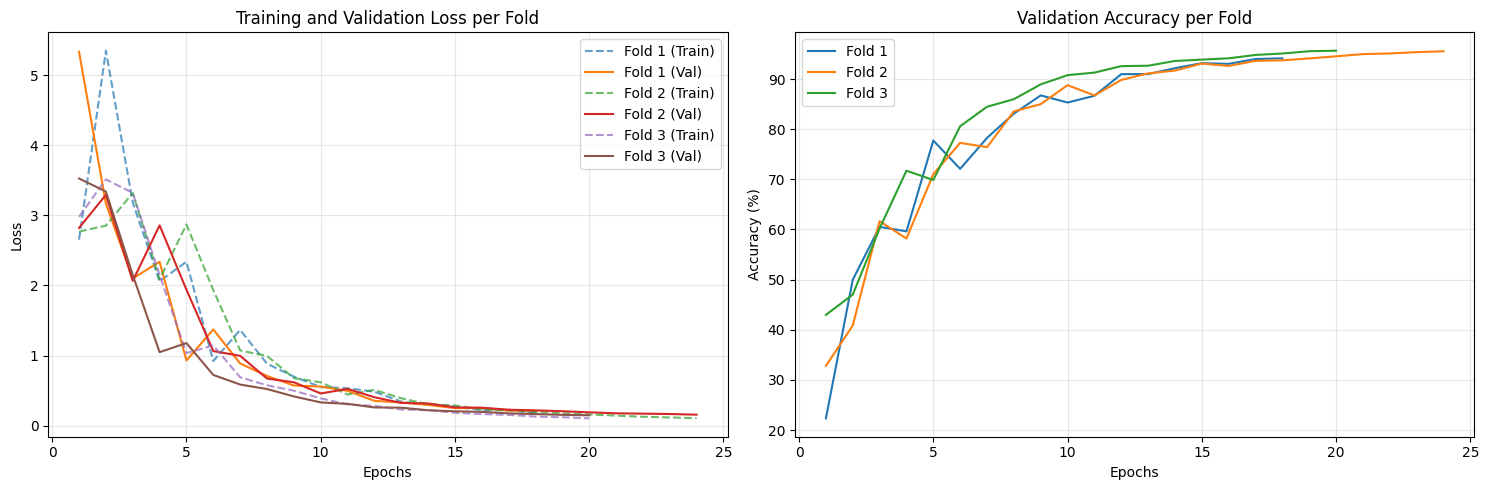


Trial 5 completed:
Parameters: {'n_neurons': (128,), 'eta_minus': 0.6, 'eta_plus': 1.3, 'min_step': 1e-06, 'max_step': 60.0}
Average accuracy across folds: 95.1125 ± 0.6910

Trial 6/10
Testing parameters: {'n_neurons': (128,), 'eta_minus': 0.7, 'eta_plus': 1.4, 'min_step': 1e-06, 'max_step': 60.0}
FOLD 1/3
Epoch [1/300], Train loss: 2.8902, Val Loss: 4.2610, Val Acc: 36.15%
Epoch [2/300], Train loss: 4.2536, Val Loss: 4.1941, Val Acc: 51.08%
Epoch [3/300], Train loss: 4.1871, Val Loss: 2.0548, Val Acc: 59.04%
Epoch [4/300], Train loss: 2.0389, Val Loss: 1.5996, Val Acc: 66.18%
Epoch [5/300], Train loss: 1.5920, Val Loss: 2.5954, Val Acc: 51.30%
Epoch [6/300], Train loss: 2.6056, Val Loss: 1.2977, Val Acc: 74.94%
Epoch [7/300], Train loss: 1.3006, Val Loss: 0.9952, Val Acc: 80.53%
Epoch [8/300], Train loss: 0.9998, Val Loss: 0.9318, Val Acc: 83.36%
Epoch [9/300], Train loss: 0.9137, Val Loss: 0.6392, Val Acc: 88.76%
Epoch [10/300], Train loss: 0.6157, Val Loss: 0.8570, Val Acc: 84.16%


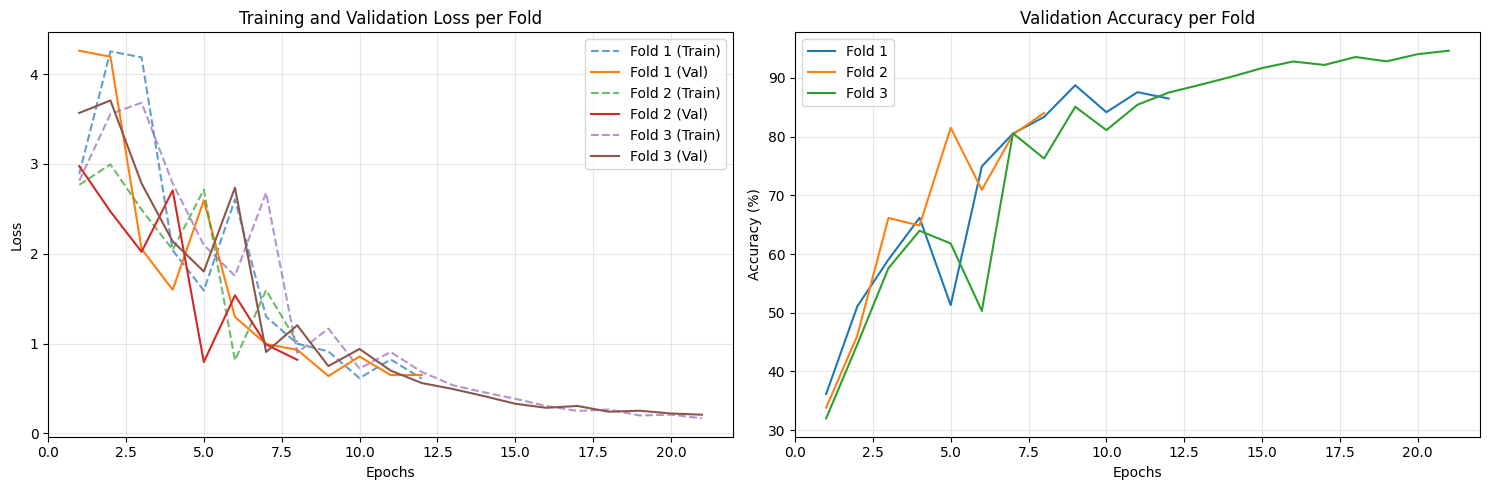


Trial 6 completed:
Parameters: {'n_neurons': (128,), 'eta_minus': 0.7, 'eta_plus': 1.4, 'min_step': 1e-06, 'max_step': 60.0}
Average accuracy across folds: 89.1417 ± 4.3436

Trial 7/10
Testing parameters: {'n_neurons': (64,), 'eta_minus': 0.7, 'eta_plus': 1.4, 'min_step': 1e-07, 'max_step': 50.0}
FOLD 1/3
Epoch [1/300], Train loss: 2.9138, Val Loss: 2.5832, Val Acc: 39.47%
Epoch [2/300], Train loss: 2.5758, Val Loss: 1.8479, Val Acc: 49.96%
Epoch [3/300], Train loss: 1.8449, Val Loss: 1.9126, Val Acc: 52.90%
Epoch [4/300], Train loss: 1.8908, Val Loss: 1.1830, Val Acc: 68.09%
Epoch [5/300], Train loss: 1.1858, Val Loss: 1.2600, Val Acc: 67.92%
Epoch [6/300], Train loss: 1.2467, Val Loss: 1.1687, Val Acc: 70.19%
Epoch [7/300], Train loss: 1.1636, Val Loss: 0.7237, Val Acc: 82.34%
Epoch [8/300], Train loss: 0.7092, Val Loss: 0.6604, Val Acc: 83.06%
Epoch [9/300], Train loss: 0.6476, Val Loss: 0.6930, Val Acc: 81.66%
Epoch [10/300], Train loss: 0.6887, Val Loss: 0.5685, Val Acc: 86.46%
E

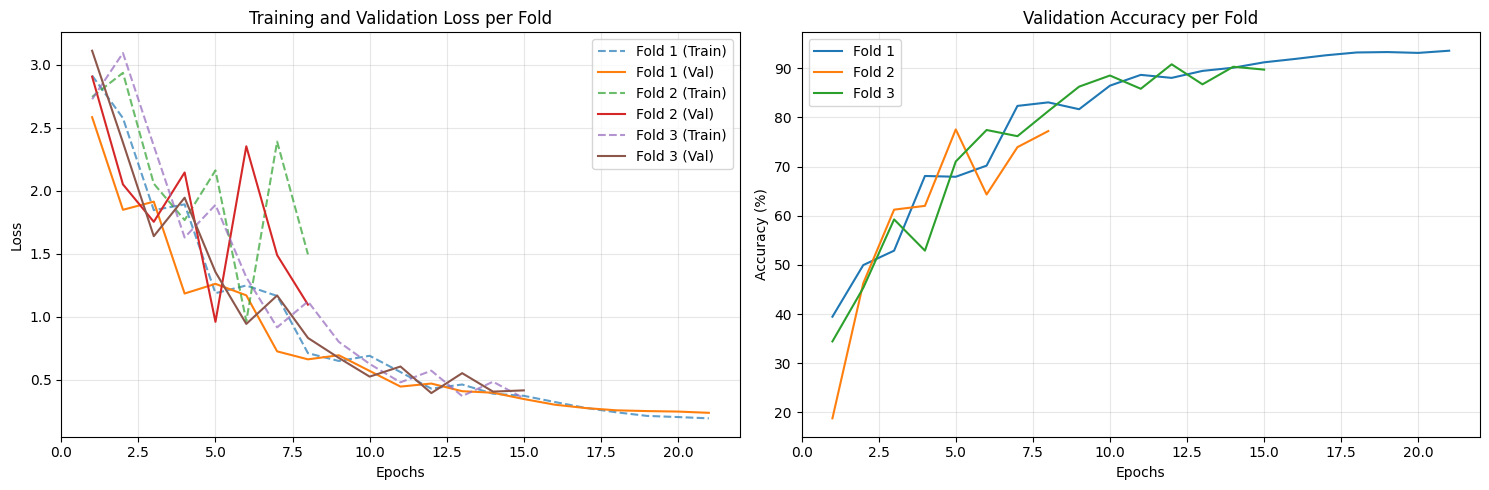


Trial 7 completed:
Parameters: {'n_neurons': (64,), 'eta_minus': 0.7, 'eta_plus': 1.4, 'min_step': 1e-07, 'max_step': 50.0}
Average accuracy across folds: 87.3062 ± 6.9859

Trial 8/10
Testing parameters: {'n_neurons': (64,), 'eta_minus': 0.5, 'eta_plus': 1.2, 'min_step': 1e-06, 'max_step': 50.0}
FOLD 1/3
Epoch [1/300], Train loss: 3.0377, Val Loss: 3.7190, Val Acc: 21.82%
Epoch [2/300], Train loss: 3.6965, Val Loss: 3.0458, Val Acc: 45.05%
Epoch [3/300], Train loss: 3.0266, Val Loss: 2.1362, Val Acc: 52.04%
Epoch [4/300], Train loss: 2.1246, Val Loss: 1.3823, Val Acc: 67.74%
Epoch [5/300], Train loss: 1.3712, Val Loss: 0.9404, Val Acc: 72.66%
Epoch [6/300], Train loss: 0.9404, Val Loss: 0.8048, Val Acc: 76.00%
Epoch [7/300], Train loss: 0.8065, Val Loss: 0.5988, Val Acc: 81.75%
Epoch [8/300], Train loss: 0.5944, Val Loss: 0.5213, Val Acc: 83.85%
Epoch [9/300], Train loss: 0.5165, Val Loss: 0.4236, Val Acc: 87.43%
Epoch [10/300], Train loss: 0.4221, Val Loss: 0.3885, Val Acc: 88.28%
Ep

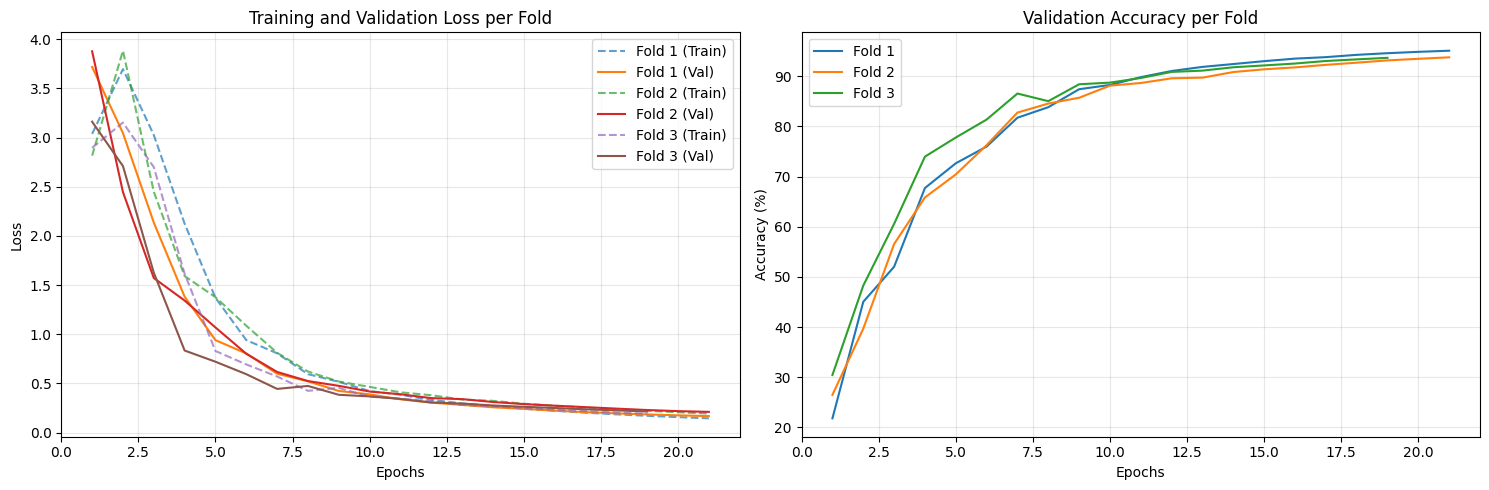


Trial 8 completed:
Parameters: {'n_neurons': (64,), 'eta_minus': 0.5, 'eta_plus': 1.2, 'min_step': 1e-06, 'max_step': 50.0}
Average accuracy across folds: 94.1938 ± 0.6465

Trial 9/10
Testing parameters: {'n_neurons': (256, 128), 'eta_minus': 0.6, 'eta_plus': 1.3, 'min_step': 1e-05, 'max_step': 60.0}
FOLD 1/3
Epoch [1/300], Train loss: 2.7565, Val Loss: 4.1842, Val Acc: 36.58%
Epoch [2/300], Train loss: 4.1877, Val Loss: 6.2773, Val Acc: 24.07%
Epoch [3/300], Train loss: 6.2906, Val Loss: 3.3995, Val Acc: 50.60%
Epoch [4/300], Train loss: 3.4043, Val Loss: 4.2161, Val Acc: 46.49%
Epoch [5/300], Train loss: 4.2432, Val Loss: 2.9380, Val Acc: 53.58%
Epoch [6/300], Train loss: 2.9204, Val Loss: 1.2721, Val Acc: 72.91%
Epoch [7/300], Train loss: 1.2670, Val Loss: 1.9285, Val Acc: 62.12%
Epoch [8/300], Train loss: 1.9299, Val Loss: 1.1410, Val Acc: 78.42%
Epoch [9/300], Train loss: 1.1198, Val Loss: 0.7083, Val Acc: 84.86%
Epoch [10/300], Train loss: 0.7014, Val Loss: 0.8758, Val Acc: 82.2

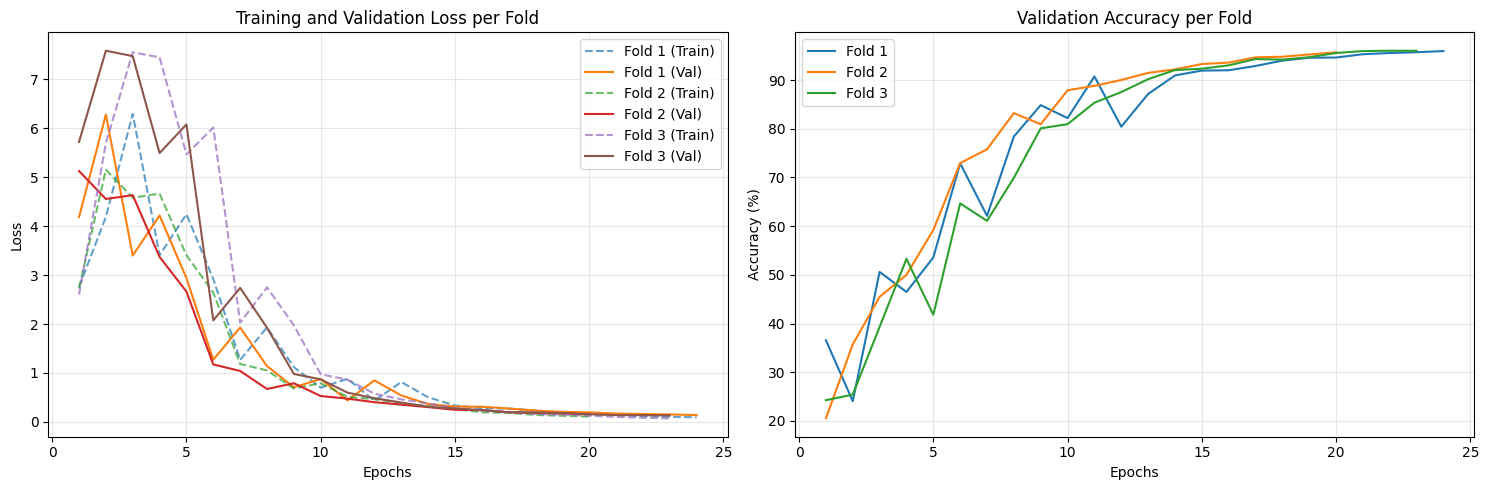


Trial 9 completed:
Parameters: {'n_neurons': (256, 128), 'eta_minus': 0.6, 'eta_plus': 1.3, 'min_step': 1e-05, 'max_step': 60.0}
Average accuracy across folds: 95.9042 ± 0.1389

Trial 10/10
Testing parameters: {'n_neurons': (64,), 'eta_minus': 0.5, 'eta_plus': 1.2, 'min_step': 1e-07, 'max_step': 50.0}
FOLD 1/3
Epoch [1/300], Train loss: 2.5921, Val Loss: 2.7694, Val Acc: 40.04%
Epoch [2/300], Train loss: 2.7648, Val Loss: 1.7934, Val Acc: 54.64%
Epoch [3/300], Train loss: 1.7747, Val Loss: 1.2988, Val Acc: 67.49%
Epoch [4/300], Train loss: 1.2863, Val Loss: 1.0268, Val Acc: 72.72%
Epoch [5/300], Train loss: 1.0279, Val Loss: 0.6440, Val Acc: 81.61%
Epoch [6/300], Train loss: 0.6471, Val Loss: 0.6215, Val Acc: 82.30%
Epoch [7/300], Train loss: 0.6151, Val Loss: 0.5055, Val Acc: 84.91%
Epoch [8/300], Train loss: 0.5023, Val Loss: 0.4342, Val Acc: 87.09%
Epoch [9/300], Train loss: 0.4314, Val Loss: 0.4151, Val Acc: 87.81%
Epoch [10/300], Train loss: 0.4091, Val Loss: 0.3578, Val Acc: 89.

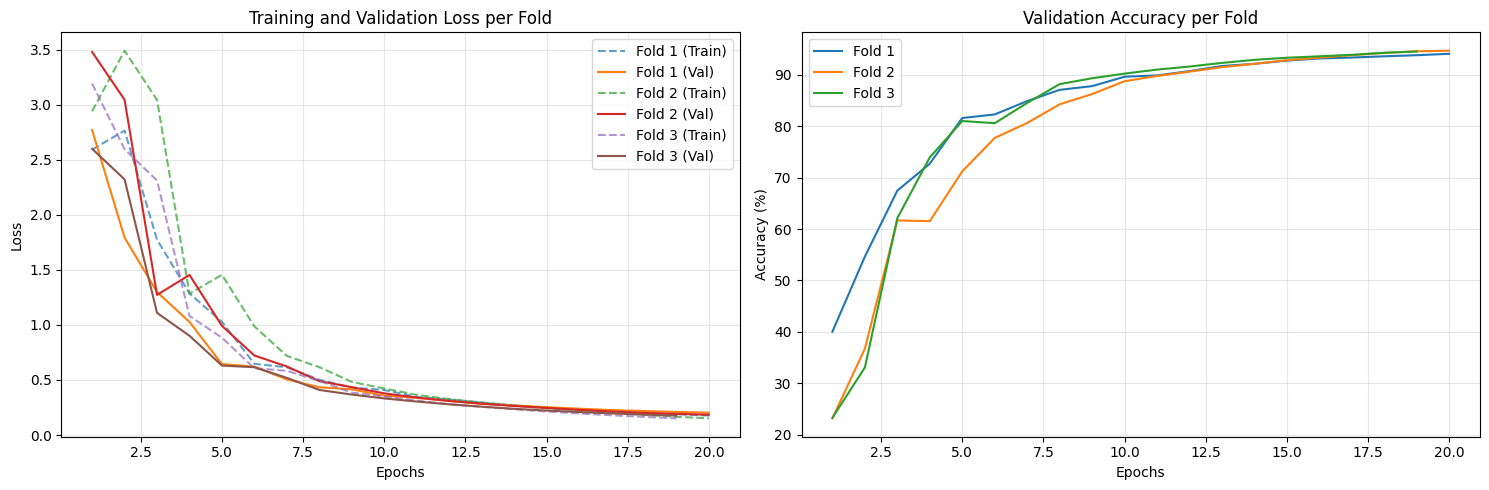


Trial 10 completed:
Parameters: {'n_neurons': (64,), 'eta_minus': 0.5, 'eta_plus': 1.2, 'min_step': 1e-07, 'max_step': 50.0}
Average accuracy across folds: 94.4521 ± 0.2558

Best trial results:
Parameters: {'n_neurons': (256, 128), 'eta_minus': 0.6, 'eta_plus': 1.3, 'min_step': 1e-05, 'max_step': 60.0}
Accuracy: 95.9042 ± 0.1389


In [6]:
seed = 42

set_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters for the random search
n_trials = 10

# Hyperparameters for the k-fold cross-validation
k_folds = 3

# Hyperparameters for the neural network
input_size = 28 * 28
num_classes = 10

# Hyperparameters for the training
num_epochs = 300
train_batch_size = None # degined after splitting the dataset (batch learning)
val_batch_size = None # defined after splitting the dataset (batch learning)
learning_rate = 0.01

# Hyperparameters for the Early Stopping
patience = 3
min_delta = 0.040

trial_results = []

param_space = {
    'n_neurons': [(64,), (128,), (128, 64), (256, 128)],
    'eta_minus': [0.7, 0.6, 0.5],
    'eta_plus': [1.4, 1.3, 1.2],
    'min_step': [1e-7, 1e-6, 1e-5],
    'max_step': [70, 60, 50]
}

for trial in range(n_trials):
    params = {
        'n_neurons': random.choice(param_space['n_neurons']),
        'eta_minus': float(np.random.choice(param_space['eta_minus'])),
        'eta_plus': float(np.random.choice(param_space['eta_plus'])),
        'min_step': float(np.random.choice(param_space['min_step'])),
        'max_step': float(np.random.choice(param_space['max_step']))
    }

    print(f"\nTrial {trial+1}/{n_trials}")
    print(f"Testing parameters: {params}")
    
    fold_train_losses = []
    fold_val_losses = []
    fold_val_accuracies = []

    
    kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)
        
    targets = train_dataset.dataset.targets[train_dataset.indices]
    
    for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dataset, targets)):
        print(f'FOLD {fold+1}/{k_folds}')
        
        train_subset = torch.utils.data.Subset(train_dataset, train_ids)
        val_subset = torch.utils.data.Subset(train_dataset, val_ids)
        
        train_batch_size = len(train_subset)
        val_batch_size = len(val_subset)

        train_loader = create_dataloaders(train_subset, train_batch_size, num_workers=8, shuffle=True)
        val_loader = create_dataloaders(val_subset, val_batch_size, num_workers=8, shuffle=False)

        model, criterion, optimizer = create_model(
            input_size, params['n_neurons'], num_classes, 
            learning_rate, params['eta_minus'], params['eta_plus'], 
            params['min_step'], params['max_step'], device
        )
        
        train_losses, val_losses, val_accuracies = train_model(
            model, train_loader, val_loader, 
            criterion, optimizer, device, 
            num_epochs, patience, min_delta,
            verbose=False
        )

        fold_train_losses.append(train_losses)
        fold_val_losses.append(val_losses)
        fold_val_accuracies.append(val_accuracies)
    
    plot_fold_results(fold_train_losses, fold_val_losses, fold_val_accuracies)

    best_fold_accuracies = [max(acc_list) for acc_list in fold_val_accuracies]
    avg_accuracy = np.mean(best_fold_accuracies)
    std_accuracy = np.std(best_fold_accuracies)
    trial_results.append((params, avg_accuracy, std_accuracy))
    
    print(f"\nTrial {trial + 1} completed:")
    print(f"Parameters: {params}")
    print(f"Average accuracy across folds: {avg_accuracy:.4f} ± {std_accuracy:.4f}")

best_trial = max(trial_results, key=lambda x: x[1])
print("\nBest trial results:")
print(f"Parameters: {best_trial[0]}")
print(f"Accuracy: {best_trial[1]:.4f} ± {best_trial[2]:.4f}")

### Defenition and training of a model with the best hyperparameter found

Epoch [1/300], Train loss: 2.5042, Val Loss: 7.7923, Val Acc: 25.11%
Epoch [2/300], Train loss: 7.7794, Val Loss: 10.5787, Val Acc: 35.14%
Epoch [3/300], Train loss: 10.5776, Val Loss: 8.4036, Val Acc: 26.24%
Epoch [4/300], Train loss: 8.4036, Val Loss: 4.1452, Val Acc: 49.19%
Epoch [5/300], Train loss: 4.1439, Val Loss: 4.0157, Val Acc: 53.12%
Epoch [6/300], Train loss: 3.9900, Val Loss: 1.8185, Val Acc: 69.87%
Epoch [7/300], Train loss: 1.8244, Val Loss: 1.8383, Val Acc: 70.49%
Epoch [8/300], Train loss: 1.8338, Val Loss: 1.5878, Val Acc: 70.13%
Epoch [9/300], Train loss: 1.5688, Val Loss: 0.6205, Val Acc: 84.56%
Epoch [10/300], Train loss: 0.6138, Val Loss: 1.0002, Val Acc: 77.60%
Epoch [11/300], Train loss: 0.9867, Val Loss: 0.6590, Val Acc: 83.83%
Epoch [12/300], Train loss: 0.6488, Val Loss: 0.5302, Val Acc: 86.46%
Epoch [13/300], Train loss: 0.5230, Val Loss: 0.4232, Val Acc: 88.98%
Epoch [14/300], Train loss: 0.4174, Val Loss: 0.3209, Val Acc: 91.72%
Epoch [15/300], Train loss:

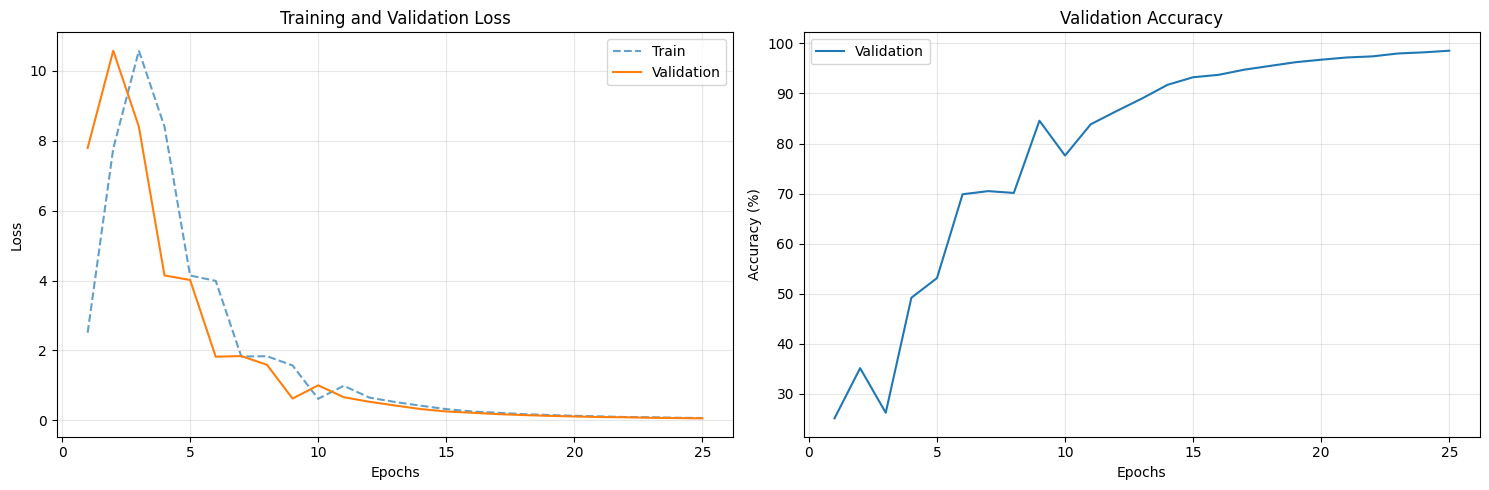

In [7]:
best_params = best_trial[0]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters for the neural network
input_size = 28 * 28
num_classes = 10

# Hyperparameters for the training
num_epochs = 300
train_batch_size = len(train_dataset) 
val_batch_size = len(val_dataset)
learning_rate = 0.01

# Hyperparameters for the Early Stopping
patience = 3
min_delta = 0.040

train_loader = create_dataloaders(train_dataset, train_batch_size, num_workers=8, shuffle=True) 
test_loader = create_dataloaders(test_dataset, val_batch_size, num_workers=8, shuffle=False)

best_model, criterion, optimizer = create_model(
    input_size=input_size,
    n_neurons=best_params['n_neurons'],
    num_classes=num_classes, 
    learning_rate=learning_rate,
    eta_minus=best_params['eta_minus'],
    eta_plus=best_params['eta_plus'],
    min_step=best_params['min_step'],
    max_step=best_params['max_step'],
    device=device
)

train_losses, val_losses, val_accuracies = train_model(
    best_model, train_loader, val_loader, 
    criterion, optimizer, device, 
    num_epochs, patience, min_delta,
    verbose=False
)

plot_results(train_losses, val_losses, val_accuracies)

### Best model testing

Test accuracy: 97.04%


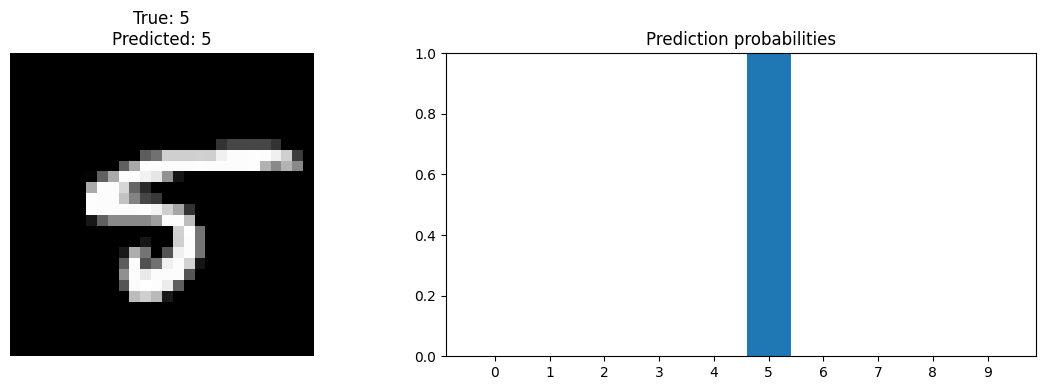

In [8]:
_, acc = validate_model(best_model, test_loader, criterion, device)
print(f'Test accuracy: {acc:.2f}%')

plot_predictions(best_model, test_loader, device)